# Set-Up

In [3]:
import logging 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from sklearn.metrics import pairwise_distances

In [204]:
logging.basicConfig(filename='../debug_info.log', encoding='utf-8', level=logging.DEBUG)

# Fetch data

In [205]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [22]:
data_1day = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_1date = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2day = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2date = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5date = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5day = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')

# Cleaning Data
## Adjust Data types and columns

In [23]:
def clean_up(dataframe):

    dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]
    dataframe = dataframe.apply(pd.to_numeric, args={'coerce'})
    dataframe.columns = [col.replace('United Kingdom', 'UK') for col in dataframe.columns]

    if type(dataframe.index[0])  == str and ('density'.title() in dataframe.index[0]  or 'population'.title() in dataframe.index[0]):

        if '/' not in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].copy()
            dataframe = dataframe.iloc[1:].copy()
            dataframe_with_metric.index.name = 'Day'
            dataframe.index = dataframe.index.astype(int)
            dataframe.index.name = 'Day'
            return (dataframe, dataframe_with_metric)
        
        elif '/' in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].copy()
            dataframe_with_metric.index.name = 'Date'
            dataframe = dataframe.iloc[1:].copy()
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return (dataframe, dataframe_with_metric)
    
    elif type(dataframe.index[0])  == str and '/' in dataframe.index[1]:

        if np.nan in dataframe.index:

            dataframe = dataframe.iloc[:-5].copy()
            dataframe_metric = dataframe.iloc[-4:].copy()
            dataframe_metric.index.name = 'Date'
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return dataframe, dataframe_metric
        
        else:
            
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            dataframe.index.name = 'Date'
            return dataframe
    else: # type index = int
        
        dataframe.index.name = 'Day'
        return dataframe


data_1day = clean_up(data_1day)
data_1date, data_1date_metrics = clean_up(data_1date)
data_2day, data_2day_population = clean_up(data_2day)
data_2date, data_2date_population = clean_up(data_2date)
data_5date, data_5date_density = clean_up(data_5date)
data_5day, data_5day_density = clean_up(data_5day)

## Trying the 4 steps algorithm 
- step 1: no code
- step 2: Calculate all the rates of change for every pair xj{ti}, xj{ti+1}, and find number of day kj when for the first time rate appears to be larger than 20% of the mean value of previous initial rates (that are always small in our time series).
- step 3: For all time series xj{ti} keep terms from i=k...m where k minimum of all kj.
- step 4: Run the agglomerative clustering algorithm with single/complete linkage and Eu-
clidean distance.

In [ ]:
data_1day_pct_change = data_1day.pct_change().iloc[1:]
data_1day_pct_change


In [ ]:
data_1day_pct_change_accumulative_avg = data_1day_pct_change.expanding().mean()
data_1day_pct_change_accumulative_avg.head(5)

In [ ]:
data_1day_pct_change > data_1day_pct_change_accumulative_avg * 0.2 

# Visualizations (Cases per Day)
## Choose relevant columns - truncating data

In [24]:
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day = last_day[:30]
    data_date = data_date[last_day.index]
    return data_date

def truncate_day(data_day, data_date):
    data_day = data_day.copy()
    columns = list(set(data_day.columns) & set(data_date.columns))
    first_occ = data_date[columns] > 0 
    first_occ = first_occ.apply(pd.Series.idxmax)
    #first_occ = pd.to_datetime(first_occ, dayfirst = True)
    first_occ = first_occ.sort_values(ascending = True)
    first_occ = first_occ[:30]
    data_day = data_day[first_occ.index] 
    return data_day

#The 1b (1date) dataset contains five additional rows with statistics #FIXED IN CLEANUP
#Truncate them for consistency of the dataset (each row refers to a specific date)

data_1date_trunc = truncate_date(data_1date) 
data_2date_trunc = truncate_date(data_2date)
data_5date_trunc = truncate_date(data_5date)
data_1day_trunc = truncate_day(data_1day, data_1date)   
data_2day_trunc = truncate_day(data_2day, data_2date)
data_5day_trunc = truncate_day(data_5day, data_5date)

## Plot Cases

### Absolute cases

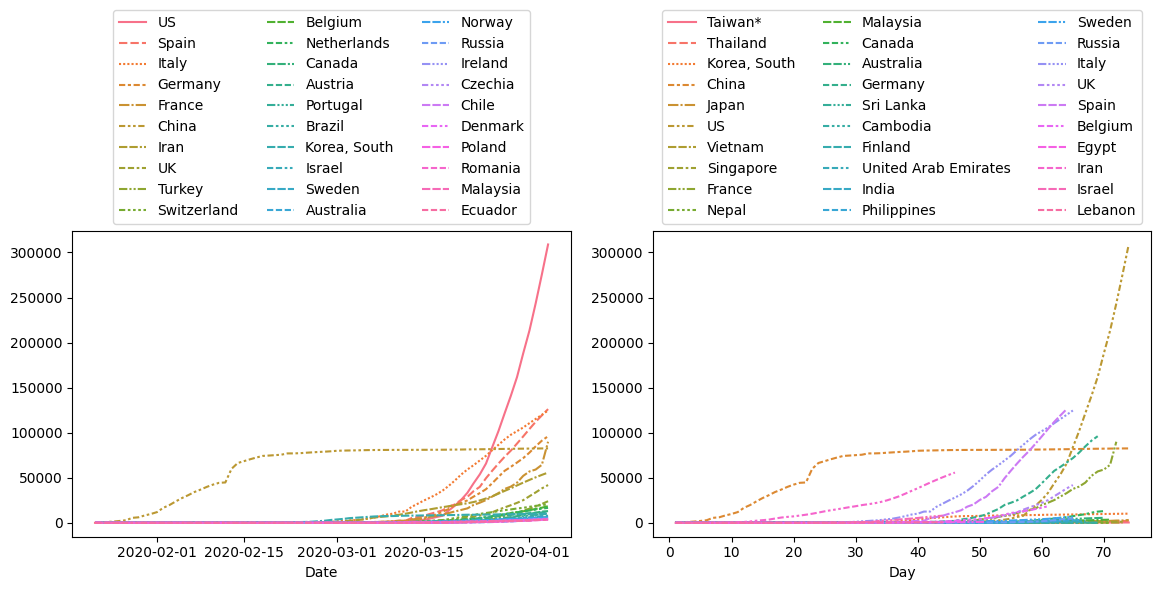

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_1date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_1day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()


### Cases per 1 million

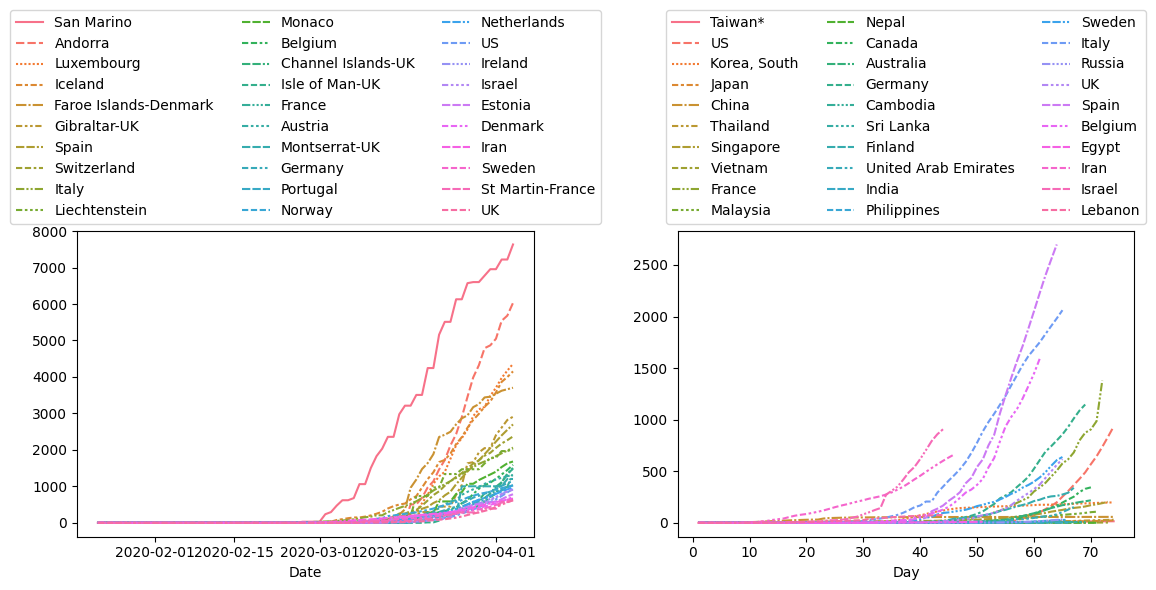

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_2date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_2day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()
#TODO fix positions and number of columns legend

### Cases per population per land

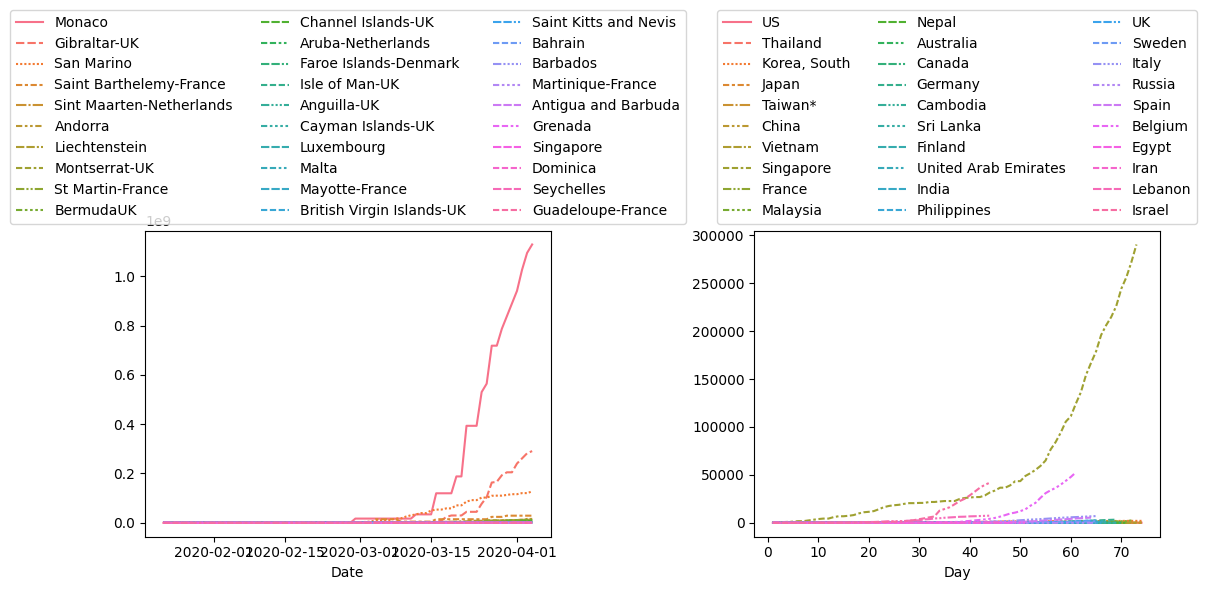

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_5date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_5day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()

# Agglomerative Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
def plot_hierarchy(data, ax):
    data = data.transpose()
    linkage_matrix = linkage(data, method='single', metric='euclidean')
    R = dendrogram(linkage_matrix)

    country_names = data.index.to_list()
    temp = {R['leaves'][i]: country_names[i] for i in range(len(R['leaves']))}
    def llf(i):
        return '{}---{}'.format(temp[i], i)

    dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
    )
    ax.set_xticks([])

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

plot_hierarchy(data_1date_trunc, ax=axes[0])
plot_hierarchy(data_2date_trunc, ax=axes[1])

plt.savefig('../figures/Clustering1')